In [1]:
# imports
from astropy.io import fits
from scipy import interpolate as sin
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotting as myP
import numpy as np
import csv 
import match

In [2]:
# path variables 
path_cat = 'D:\IfA REU\Catalogs'
path_fig = 'D:\IfA REU\IfA-REU-Project\Figures'
path_csv = 'D:\IfA REU\IfA-REU-Project\Lists'

# Read CSV

In [3]:
# read from a given csv file and return a list of its contents 
def ReadFile(filename) : 
    # initialize list
    file = []
    # open csv file
    with open(filename, newline='') as csv_file : 
        reader = csv.reader(csv_file, delimiter=',', quotechar='"')
        # output file into list for easy access
        for row in reader :
            file.append(row)
    # print column names 
    print(filename, '\tcolumns: ', file[0])
    # return an array of type int with column names clipped off
    return(file[1:])

In [4]:
# read AGN ID and index from csv files
agn_irSel20 = np.array(ReadFile(path_csv+'\Match_COSMOS2020_IRAGN_to_COSMOS2020.csv'), dtype=int)
zMatch      = np.array(ReadFile(path_cat+'\COSMOS_z_matches.csv'))

D:\IfA REU\IfA-REU-Project\Lists\Match_COSMOS2020_IRAGN_to_COSMOS2020.csv 	columns:  ['ID', 'i']
D:\IfA REU\Catalogs\COSMOS_z_matches.csv 	columns:  ['ID', 'z']


In [5]:
# transpose arrays to get columns
agn_irSel20_id, agn_irSel20_i = agn_irSel20.T
zMatch_id, zMatch_z = zMatch.T

# get correct data type
zMatch_id = np.array(zMatch_id, dtype=int)
zMatch_z  = np.array(zMatch_z,  dtype=float)

# Read Catalog

In [6]:
# open COSMOS 2020 catalog file and get data 
inf20 = fits.open(path_cat+'\COSMOS2020_CLASSIC_R1_v2.0_master.fits')
data20 = inf20[1].data
cols20 = inf20[1].columns
# head20 = inf20[0].header
inf20.close()

In [7]:
# print(cols20)

# Get Data From Catalog 

In [8]:
# get photometry table values
flux_nu_uJy = np.array([   
        # The Galaxy Evolution Explorer (GALEX)
        np.array(data20['GALEX_FUV_FLUX']), 
        np.array(data20['GALEX_NUV_FLUX']),
        # Subaru / Hyper Suprime-Cam
        np.array(data20['HSC_g_FLUX_APER2']),
        np.array(data20['HSC_r_FLUX_APER2']),
        np.array(data20['HSC_i_FLUX_APER2']),
        np.array(data20['HSC_z_FLUX_APER2']),
        np.array(data20['HSC_y_FLUX_APER2']),
        # Paranal VISTA / VIRCAM
        np.array(data20['UVISTA_J_FLUX_APER2']),
        np.array(data20['UVISTA_H_FLUX_APER2']),
        np.array(data20['UVISTA_Ks_FLUX_APER2']),
        # Spitzer Large Area Survey with Hyper-Suprime-Cam (SPLASH) 
        np.array(data20['SPLASH_CH1_FLUX']),
        np.array(data20['SPLASH_CH2_FLUX']),
        np.array(data20['SPLASH_CH3_FLUX']),
        np.array(data20['SPLASH_CH4_FLUX']),
        # FIR
        np.array(data20['FIR_24_FLUX']),    # Spitzer/MIPS.24mu
        np.array(data20['FIR_100_FLUX']),   # Herschel/Pacs.green
        np.array(data20['FIR_160_FLUX']),   # Herschel/Pacs.red
        np.array(data20['FIR_250_FLUX']),   # Herschel/SPIRE.PSW
        np.array(data20['FIR_350_FLUX']),   # Herschel/SPIRE.PMW
        np.array(data20['FIR_500_FLUX'])    # Herschel/SPIRE.PLW
    ])  

# get photometry table values
flux_err_nu_uJy = np.array([   
        # The Galaxy Evolution Explorer (GALEX)
        np.array(data20['GALEX_FUV_FLUXERR']), 
        np.array(data20['GALEX_NUV_FLUXERR']),
        # Subaru / Hyper Suprime-Cam
        np.array(data20['HSC_g_FLUXERR_APER2']),
        np.array(data20['HSC_r_FLUXERR_APER2']),
        np.array(data20['HSC_i_FLUXERR_APER2']),
        np.array(data20['HSC_z_FLUXERR_APER2']),
        np.array(data20['HSC_y_FLUXERR_APER2']),
        # Paranal VISTA / VIRCAM
        np.array(data20['UVISTA_J_FLUXERR_APER2']),
        np.array(data20['UVISTA_H_FLUXERR_APER2']),
        np.array(data20['UVISTA_Ks_FLUXERR_APER2']),
        # Spitzer Large Area Survey with Hyper-Suprime-Cam (SPLASH) 
        np.array(data20['SPLASH_CH1_FLUXERR']),
        np.array(data20['SPLASH_CH2_FLUXERR']),
        np.array(data20['SPLASH_CH3_FLUXERR']),
        np.array(data20['SPLASH_CH4_FLUXERR']),
        # FIR
        np.array(data20['FIR_24_FLUXERR']),    # Spitzer/MIPS.24mu
        np.array(data20['FIR_100_FLUXERR']),   # Herschel/Pacs.green
        np.array(data20['FIR_160_FLUXERR']),   # Herschel/Pacs.red
        np.array(data20['FIR_250_FLUXERR']),   # Herschel/SPIRE.PSW
        np.array(data20['FIR_350_FLUXERR']),   # Herschel/SPIRE.PMW
        np.array(data20['FIR_500_FLUXERR'])    # Herschel/SPIRE.PLW
    ]) 

# transpose so [i] is a source, not a column
flux_nu_uJy = flux_nu_uJy.T
flux_err_nu_uJy = flux_err_nu_uJy.T

# change bad values to NaN
flux_nu_uJy = np.where(flux_nu_uJy <= float(0), float('nan'), flux_nu_uJy)
flux_nu_uJy = np.where(flux_err_nu_uJy/flux_nu_uJy >= 0.5, float('nan'), flux_nu_uJy) 

# print info
print('Table shape:', np.shape(flux_nu_uJy))

Table shape: (1720700, 20)


In [9]:
# list wavelengths of the photometry filters (in Angstroms)
# -- Used lambda_ref from: http://svo2.cab.inta-csic.es/theory/fps3/
lam_A = np.array([
          1535.08,      # 'GALEX_FUV_FLUX'
          2300.79,      # 'GALEX_NUV_FLUX'
          4798.21,      # 'HSC_g_FLUX_APER2'
          6218.44,      # 'HSC_r_FLUX_APER2'
          7727.02,      # 'HSC_i_FLUX_APER2'
          8908.50,      # 'HSC_z_FLUX_APER2'
          9775.07,      # 'HSC_y_FLUX_APER2'
         12524.83,      # 'UVISTA_J_FLUX_APER2'
         16432.40,      # 'UVISTA_H_FLUX_APER2'
         21521.52,      # 'UVISTA_Ks_FLUX_APER2'
         35378.41,      # 'SPLASH_CH1_FLUX' 
         44780.49,      # 'SPLASH_CH2_FLUX' 
         56961.77,      # 'SPLASH_CH3_FLUX' 
         77978.39,      # 'SPLASH_CH4_FLUX' 
        235934.61,      # 'FIR_24_FLUX'      
             1.01e+6,   # 'FIR_100_FLUX'
             1.62e+6,   # 'FIR_160_FLUX'
             2.48e+6,   # 'FIR_250_FLUX'
             3.48e+6,   # 'FIR_350_FLUX'
             5.00e+6    # 'FIR_500_FLUX'
    ])

# print info 
print('Number of Filters: ', len(lam_A))

Number of Filters:  20


# Refine Data

In [10]:
# get mask of valid redshifts
mask_z = (zMatch_z >= 0) & (zMatch_z < 99)

# apply mask to remove -99 redshifts
zValid_id = zMatch_id[mask_z]
zValid_z  = zMatch_z[mask_z]

# print info
print('number of sources in z matches:\t',  len(zMatch_id))
print('Number of sources with z:\t',        len(zValid_id))

number of sources in z matches:	 865086
Number of sources with z:	 485793


In [11]:
# match redshifts to agn
key_z, key_agn = match.match(zValid_id, agn_irSel20_id)

# apply key to get parallel lists if agn-z matches
z_id    = zValid_id[key_z]
z_z     = zValid_z[key_z]
agn_id  = agn_irSel20_id[key_agn]
agn_i   = agn_irSel20_i[key_agn]

# get flux table of agn sources 
agn_flux_nu_uJy = flux_nu_uJy[agn_i]

# print info
print('Number of Donley Sources:\t', len(agn_irSel20_id))
print('Number of Donley sources w/ z:\t', len(agn_id))

Number of Donley Sources:	 2287
Number of Donley sources w/ z:	 1533


In [12]:
# initialize table of rest frame wavelengths
lamR_A = np.zeros(agn_flux_nu_uJy.shape)

# get rest wavelength 
for i,z in enumerate(z_z) : 
    # lambda_rest = lambda_observed / (1+z)
    lamR_A[i] = lam_A / (1+z)

# Convert Units

In [13]:
# convert wavelength units
lamR_cm = lamR_A * 1E-8
lamR_um = lamR_A * 1E-4
lam_um  = lam_A  * 1E-4

In [14]:
# c[cm/s]/lambda^2
c_lamR2 = 2.99792458 * 1E10  / lamR_cm**2

# convert Jy to cgs units: # 1 Jy = 10^-23 erg/s/cm2/Hz, uJy = 10^-6 Jy
agn_flux_nu_ergscm2Hz = agn_flux_nu_uJy * 1E-23 * 1E-6

# multiply F_nu by c/lam^2 to get F_lam
agn_flux_lam_ergscm3 = np.multiply(agn_flux_nu_ergscm2Hz, c_lamR2)

# lam * F_lam [erg/s/cm]
agn_lamflux_lam_ergscm2 = np.multiply(agn_flux_lam_ergscm3, lamR_cm)

# verify same shape 
print('Table shape:', np.shape(agn_lamflux_lam_ergscm2))

Table shape: (1533, 20)


# Make SED

In [15]:
# initialize list 
agn_lamflux_lam_ergscm2_NORM = []
# get shape 
numRow, numCol = lamR_um.shape

# normalize each agn source in log space 
for row in range(numRow) :
    # get x and y
    x = lamR_um[row]
    y = agn_lamflux_lam_ergscm2[row]
    # get log scale and exclude NaN
    logx = np.log10(x[~np.isnan(y)])
    logy = np.log10(y[~np.isnan(y)])
    # interpolate flux curve 
    f = sin.interp1d(logx, logy, kind='linear', fill_value='extrapolate')
    # normalize
    at1um = 10**f(np.log10(1))
    agn_lamflux_lam_ergscm2_NORM.append( y / at1um )

# convert list to array 
agn_lamflux_lam_ergscm2_NORM = np.array(agn_lamflux_lam_ergscm2_NORM)

# verify same shape 
print('Table shape:', np.shape(agn_lamflux_lam_ergscm2_NORM))


Table shape: (1533, 20)


In [16]:
# set standard plot format
myP.SetStyle()

In [17]:
def PlotSED(x,y,num,title='',offset=0) : 
    
    # plot SED curves
    for i in range(num) : 
        plt.plot(x[i+offset],y[i+offset])
        # plt.plot(x[i+offset],y[i+offset],'x',c='k')

    # axis settings
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(2E-2, 6E+2)
    plt.ylim(5E-3, 5E+2)
    plt.xlabel('$\lambda_{rest} \; [\mu m]$') 
    plt.ylabel('$Normalized \; \lambda F_{\lambda} \; [erg \; s^{-1} \; cm^{-2}]$')

    # text 
    text = 'n = '+str(num)
    plt.text(1.2E+2,1.5E-2,text)

    # set title
    if(title!='') : 
        plt.title(title)

    # show plot
    plt.grid()
    plt.show()

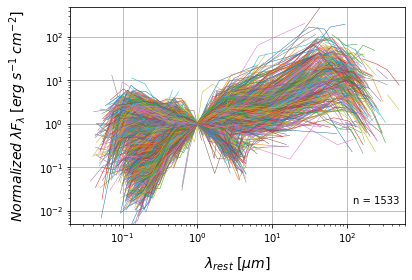

In [18]:
# plot some sources 
x = lamR_um
y = agn_lamflux_lam_ergscm2_NORM
r,c = np.shape(x)
PlotSED(x,y,num=r)

# Sort SED by Redshift 

In [19]:
# define masks for redshift bins
bin_z = np.array([
    (z_z > 0.0) & (z_z <= 0.5), (z_z > 0.5) & (z_z <= 1.0), (z_z > 1.0) & (z_z <= 1.5), 
    (z_z > 1.5) & (z_z <= 2.0), (z_z > 2.0) & (z_z <= 2.5), (z_z > 2.5) & (z_z <= 3.0), 
    (z_z > 3.0) & (z_z <= 3.5), (z_z > 3.5) & (z_z <= 4.0), (z_z > 4.0)
])

# titles of redshift bins
bin_z_title = np.array(['0.0-0.5', '0.5-1.0', '1.0-1.5', '1.5-2.0', '2.0-2.5', '2.5-3.0', '3.0-3.5', '3.5-4.0', '>4.0'])

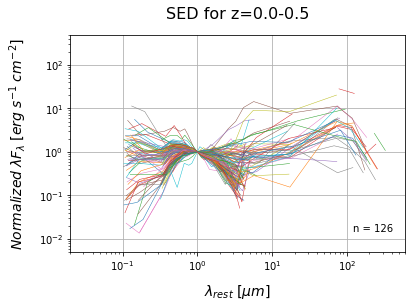

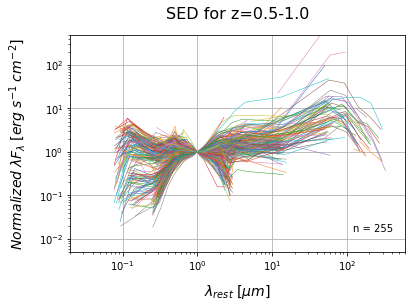

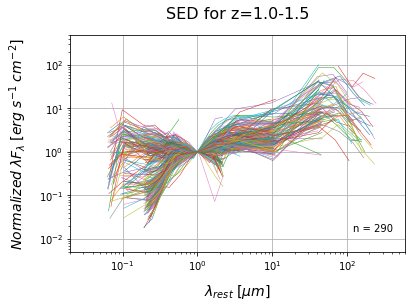

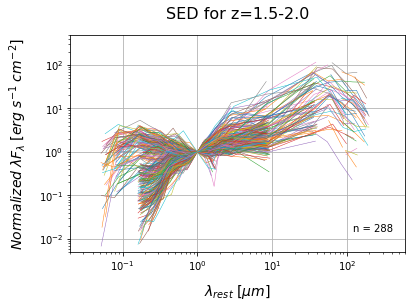

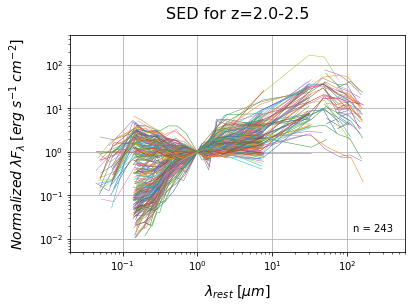

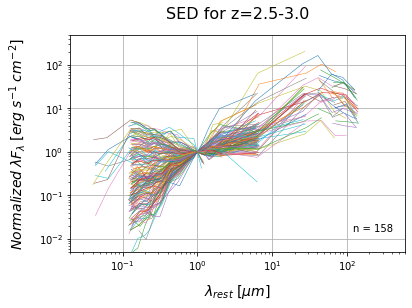

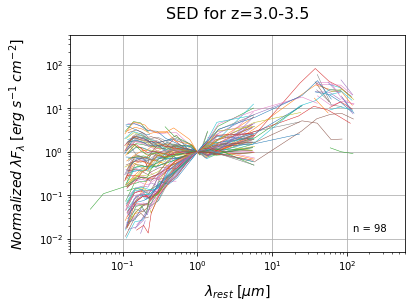

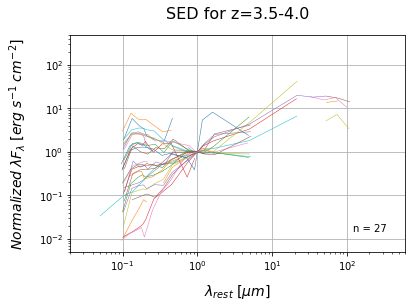

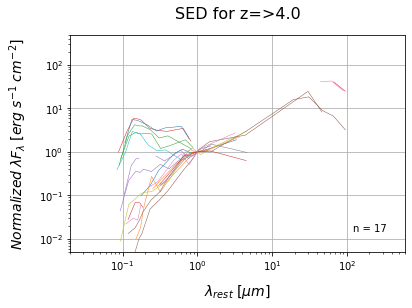

In [20]:
# plot SED for each bin 
for i,z in enumerate(bin_z) :
    x = lamR_um[z]
    y = agn_lamflux_lam_ergscm2_NORM[z]
    r,c = np.shape(x)
    t = bin_z_title[i]
    PlotSED(x,y,r,title='SED for z='+t)